### Assignment 3

##### Deliar Mohammadi, 30072994
##### John Zheng,30125258
##### Xinzhou Li, 30066080



In [109]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch_optimizer as optim

import PIL
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
import glob

### Building Train and Test Data classes

In [110]:
class Train():
    def __init__(self, root, csv_path, transform = None, ext='.jpg'):
        self.df_csv = pd.DataFrame(pd.read_csv((root+csv_path)))
        self.paths = self.df_csv['id']
        self.labels = self.df_csv['label']
        self.transform = transform
        self.root = root
        # print(self.all_file_paths)
        # print(self.all_labels)
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths.iat[i])
        img = Image.open(s)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label
    
    '''
    Selects random start point in the dataset and prints 28 images
    Inputs:
        color-> 1 to print color images, 0 for grayscale images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(3, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self[i]
            axis.imshow(x[0])
            label = x[1]
            axis.set_xlabel(label)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = self[i][0]
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self)
        avgh = totalh//len(self)
        return avgw, avgh

## Preparing training datasets, dataloaders and transforms

In [111]:
train_transform_resnet50 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.4),
    transforms.ColorJitter(brightness=0.2),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(saturation=0.5),
    
    transforms.Resize(size=256),     
    torchvision.transforms.CenterCrop(224), #required for resnet50 input: 224x224
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalized with imagenet mean and std deviation
])

In [112]:
train_dataset = Train("./Assignment 3 Dataset", "/train.csv")
print(train_dataset.calc_average_dimension())
print(len(train_dataset))

(667, 461)
4135


#### Sampels of training and test data

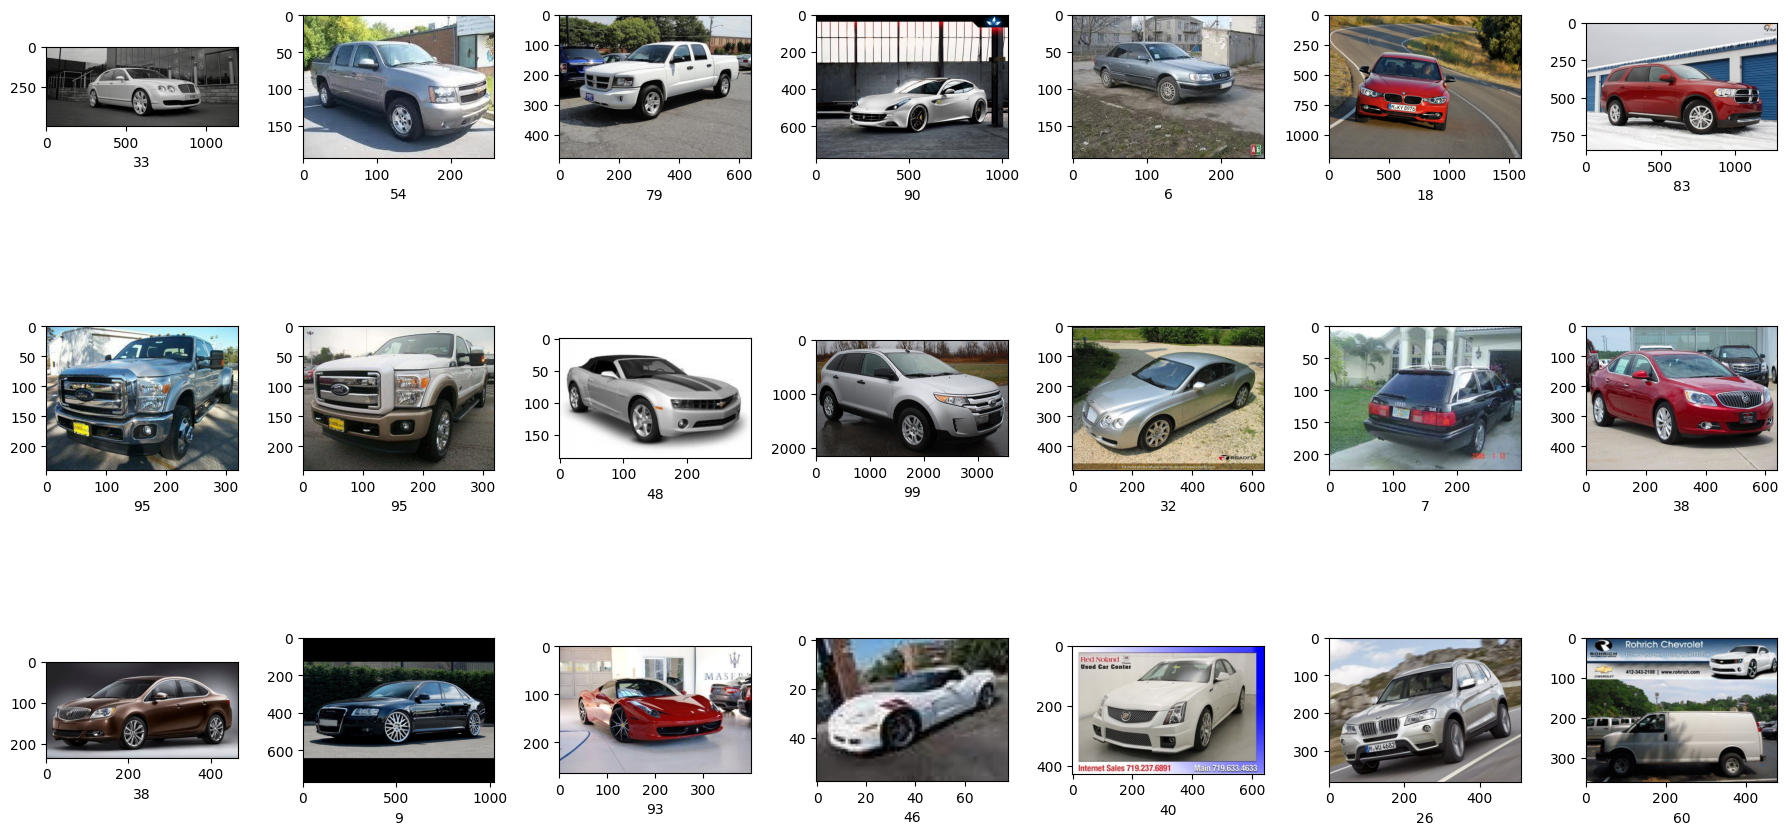

In [113]:
train_dataset.print_samples()

In [114]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Building the Model and Training

### Sources

https://pytorch.org/vision/stable/models.html

https://discuss.pytorch.org/t/what-does-it-mean-to-normalize-images-for-resnet/96160